**Installs**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import copy

#NUM_CLASSES = 102
NUM_CLASSES = 6
DEVICE = 'cuda'
MOMENTUM = 0.9

**Model definition**

In [0]:
def get_datasets(train_data_dir, test_data_dir, compose=[transforms.Resize(224),
                                                         transforms.CenterCrop(224),
                                                         transforms.ToTensor()
                                                         ]):
    train_transform = transforms.Compose(compose)
    eval_transform = transforms.Compose([
          transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.ToTensor()#,
          #transforms.Normalize((45.6068733, 0.81077038, 57.85301916), (66.92374056, 9.88349788, 49.96761776))
          ])

    '''
    if not os.path.isdir('./Homework2-Caltech101'):
        !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

    '''
    if not os.path.isdir('./AIML_project'):
        !git clone https://github.com/anphetamina/AIML_project.git
    
    train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=train_transform)
    test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform=eval_transform)

    return train_dataset, test_dataset

def test_network(net, test_dataset, batch_size):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    net.train(False)

    criterion = nn.CrossEntropyLoss()

    sum_test_losses = 0.0
    running_corrects = 0
    for images, labels in test_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      test_loss = criterion(outputs, labels)
      sum_test_losses += test_loss.item()*images.size(0)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    # Calculate loss
    test_loss = sum_test_losses / float(len(test_dataset))

    return accuracy, test_loss

def train_network(net, parameters_to_optimize, learning_rate, num_epochs, batch_size, weight_decay, step_size, gamma, train_dataset, val_dataset=None, verbosity=False, plot=False):
  
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(parameters_to_optimize, lr=learning_rate, momentum=MOMENTUM, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    net = net.to(DEVICE)
    best_net = vgg11()
    best_net = best_net.to(DEVICE)
    best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    cudnn.benchmark

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    current_step = 0
    best_val_accuracy = 0.0
    best_val_loss = 0.0
    for epoch in range(num_epochs):

        train_running_corrects = 0
        sum_train_losses = 0.0

        for images, labels in train_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            net.train()
            optimizer.zero_grad()

            outputs = net(images)
            _, preds = torch.max(outputs.data, 1)
            train_running_corrects += torch.sum(preds == labels.data).data.item()
            loss = criterion(outputs, labels)
            sum_train_losses += loss.item()*images.size(0)
            loss.backward()

            optimizer.step()
            current_step += 1
        
        # Calculate accuracy on train set
        train_accuracy = train_running_corrects / float(len(train_dataset))
        train_accuracies.append(train_accuracy)

        if val_dataset is not None:
            val_accuracy, val_loss = test_network(net, val_dataset, batch_size)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_val_loss = val_loss
                best_net.load_state_dict(net.state_dict())
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)
            acc_diff = train_accuracy-val_accuracy
            if acc_diff > 0.25:
              print("overfit -> train_accuracy {}, val_accuracy {}".format(train_accuracy, val_accuracy))
              return best_net, best_val_accuracy, best_val_loss

        

        # Calculate loss on training set
        train_loss = sum_train_losses/float(len(train_dataset))
        train_losses.append(loss)

        if verbosity:
            if val_dataset is not None:
                print("train_acc: {}, val_acc: {}, train_loss: {}, val_loss: {} ({} / {})".format(train_accuracy, val_accuracy, train_loss, val_loss, epoch+1, num_epochs))
            else:
                print("train_acc: {}, train_loss: {} ({} / {})".format(train_accuracy, train_loss, epoch+1, num_epochs))
        

        if train_accuracy < 0.25 and epoch > num_epochs*0.1 or train_accuracy < 0.35 and epoch > num_epochs*0.5:
          print("underfit -> train_accuracy = {}".format(train_accuracy))
          return best_net, best_val_accuracy, best_val_loss

        scheduler.step()

    if plot:

        fig, ax = plt.subplots()
        line1, = ax.plot(train_losses, label='Loss on training set')
        line2, = ax.plot(train_accuracies, label='Accuracy on training set')
        ax.legend()
        plt.xlabel("Epochs")
        plt.show()

        if val_dataset is not None:
            fig, ax = plt.subplots()
            line1, = ax.plot(val_accuracies, label='Accuracy on validation set', color='C2')
            line2, = ax.plot(train_accuracies, label='Accuracy on training set', color='C3')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()
        
            fig, ax = plt.subplots()
            line1, = ax.plot(val_losses, label='Loss on validation set', color='C1')
            line2, = ax.plot(train_losses, label='Loss on training set', color='C7')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()

    
    return best_net, best_val_accuracy, best_val_loss


**Train + validation**

training set 809
validation set 203
train_acc: 0.18170580964153277, val_acc: 0.18226600985221675, train_loss: 1.779353533598637, val_loss: 1.7607205888907898 (1 / 50)
train_acc: 0.19777503090234858, val_acc: 0.19704433497536947, train_loss: 1.760152413612243, val_loss: 1.726006605942261 (2 / 50)
train_acc: 0.22744128553770088, val_acc: 0.22167487684729065, train_loss: 1.7442417583889955, val_loss: 1.7161729940639927 (3 / 50)
train_acc: 0.25710754017305315, val_acc: 0.3103448275862069, train_loss: 1.6953646019745816, val_loss: 1.6452216403237705 (4 / 50)
train_acc: 0.3016069221260816, val_acc: 0.23645320197044334, train_loss: 1.6592598067520576, val_loss: 1.7206044426105294 (5 / 50)
train_acc: 0.2978986402966625, val_acc: 0.3399014778325123, train_loss: 1.6601062877511212, val_loss: 1.527847541376875 (6 / 50)
train_acc: 0.2830655129789864, val_acc: 0.32019704433497537, train_loss: 1.6179320464470184, val_loss: 1.7279341890306896 (7 / 50)
train_acc: 0.33250927070457353, val_acc: 0.315270

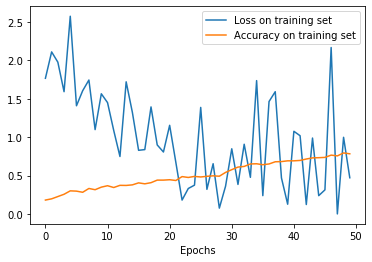

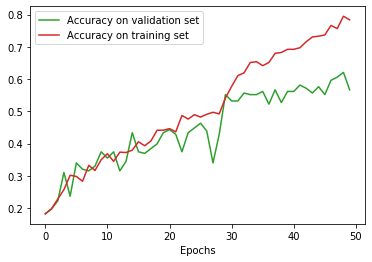

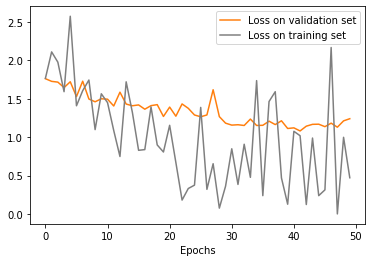

val accuracy 0.6206896551724138
val loss 1.2119932565195808


In [0]:
# lr 0.0042237987628595194, batch 15, decay 0.00042683917479004744, gamma 0.031192333743237592, val accuracy 0.4975369458128079, val loss 1.1257490495155598 [4 / 50]
# {'lr': 0.0034817317117461864, 'batch_size': 9, 'weight_decay': 0.011757203744469723, 'gamma': 0.08397906547450418}
BATCH_SIZE = 8
LR = 0.003
MOMENTUM = 0.9
WEIGHT_DECAY = 0.02
NUM_EPOCHS = 50
STEP_SIZE = 30
GAMMA = 0.08

TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
#TRAIN_DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
compose=[transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 5]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

net = vgg11()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_net, val_accuracy, val_loss = train_network(net, net.parameters(), LR, NUM_EPOCHS, BATCH_SIZE, WEIGHT_DECAY, STEP_SIZE, GAMMA, train_dataset, val_dataset=val_dataset, verbosity=True, plot=True)

print('val accuracy {}'.format(val_accuracy))
print('val loss {}'.format(val_loss))

**Testing**

In [0]:
# todo

**Random search**

In [3]:
# best scores
# 
best_accuracy = 0.0
best_loss = 0.0
val_accuracies = []
val_losses = []
import random
TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
#TRAIN_DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
compose=[transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomGrayscale(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor()
        ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 5]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))
best_net = vgg11()
best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_net = best_net.to(DEVICE)
best_set = {}
N = 50
for i in range(N):
  BATCH_SIZE = int(random.uniform(8, 16))
  LR = 10**random.uniform(-5, -3)
  MOMENTUM = 0.9
  WEIGHT_DECAY = 10**random.uniform(-6, -3)
  NUM_EPOCHS = 80
  STEP_SIZE = 48
  GAMMA = 10**random.uniform(-2, 0)
  set = {"lr": LR, "batch_size": BATCH_SIZE, "weight_decay": WEIGHT_DECAY, "gamma": GAMMA}
  print("-------------------------------------")
  print(set)
  net = vgg11()
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  current_net, val_accuracy, val_loss = train_network(net, net.parameters(), LR, NUM_EPOCHS, BATCH_SIZE, WEIGHT_DECAY, STEP_SIZE, GAMMA, train_dataset, val_dataset=val_dataset, verbosity=True)

  val_accuracies.append(val_accuracy)
  val_losses.append(val_loss)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_loss = val_loss
    best_net = copy.deepcopy(current_net)
    best_set = copy.deepcopy(set)

  print("lr {}, batch {}, decay {}, gamma {}, val accuracy {}, val loss {} [{} / {}]".format(LR, BATCH_SIZE, WEIGHT_DECAY, GAMMA, val_accuracy, val_loss, i+1, N))

print("--------------------------------------------")
print("\n{}, best val accuracy {}, best val loss {}".format(best_set, best_accuracy, best_loss))
print("val accuracies\n{}".format(val_accuracies))
print("val losses\n{}".format(val_losses))

training set 809
validation set 203
-------------------------------------
{'lr': 6.87058653262615e-05, 'batch_size': 11, 'weight_decay': 0.0002907904402306258, 'gamma': 0.3452849738179014}
train_acc: 0.17676143386897405, val_acc: 0.18226600985221675, train_loss: 1.7887585941144946, val_loss: 1.7877258355981611 (1 / 80)
train_acc: 0.18665018541409148, val_acc: 0.18226600985221675, train_loss: 1.785982954782078, val_loss: 1.7848116212290497 (2 / 80)
train_acc: 0.18665018541409148, val_acc: 0.19704433497536947, train_loss: 1.7837268041886565, val_loss: 1.782029298138736 (3 / 80)
train_acc: 0.18170580964153277, val_acc: 0.18226600985221675, train_loss: 1.7821260082117558, val_loss: 1.77940324550779 (4 / 80)
train_acc: 0.16563658838071693, val_acc: 0.18226600985221675, train_loss: 1.7808360979789857, val_loss: 1.7767154712395128 (5 / 80)
train_acc: 0.18788627935723115, val_acc: 0.18226600985221675, train_loss: 1.7786879697158398, val_loss: 1.774125811501677 (6 / 80)
train_acc: 0.21631644004

**Grid search**

In [0]:
NUM_CLASSES = 6
DEVICE = 'cuda'
#BATCH_SIZE = 16
#LR = 0.001
MOMENTUM = 0.9
#WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 100
STEP_SIZE = 60
#GAMMA = 0.1

lr_range = [0.005, 0.001, 0.0005]
batch_size_range = [16, 8]
weight_decay_range = [5e-5, 5e-3]
gamma_range = [0.1, 0.01]
hyperparameters_sets = []

for lr in lr_range:
  for batch_size in batch_size_range:
    for weight_decay in weight_decay_range:
      for gamma in gamma_range:
        hyperparameters_sets.append({'lr': lr, 'batch_size': batch_size, 'weight_decay': weight_decay, 'gamma': gamma})

for set in hyperparameters_sets:
  print(set)


TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-224'
compose=[#transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)

train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 5]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

best_net = vgg11()
best_net = best_net.to(DEVICE)
best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_set = {}
best_accuracy = 0.0
best_loss = 0.0
val_accuracies = []
val_losses = []

for set in hyperparameters_sets:

  net = vgg11()
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  current_net, val_accuracy, val_loss = train_network(net, net.parameters(), set['lr'], NUM_EPOCHS, set['batch_size'], set['weight_decay'], STEP_SIZE, set['gamma'], train_dataset, val_dataset=val_dataset)
  val_accuracies.append(val_accuracy)
  val_losses.append(val_loss)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_loss = val_loss
    best_net = copy.deepcopy(current_net)
    best_set = copy.deepcopy(set)
  
  print("({}), val accuracy {}, val loss {}".format(set, val_accuracy, val_loss))

print("\n\n({}), best val accuracy {}, best val loss {}\n".format(best_set, best_accuracy, best_loss))
print("\nval_accuracies")
print(val_accuracies)

{'lr': 0.005, 'batch_size': 16, 'weight_decay': 5e-05, 'gamma': 0.1}
{'lr': 0.005, 'batch_size': 16, 'weight_decay': 5e-05, 'gamma': 0.01}
{'lr': 0.005, 'batch_size': 16, 'weight_decay': 0.005, 'gamma': 0.1}
{'lr': 0.005, 'batch_size': 16, 'weight_decay': 0.005, 'gamma': 0.01}
{'lr': 0.005, 'batch_size': 8, 'weight_decay': 5e-05, 'gamma': 0.1}
{'lr': 0.005, 'batch_size': 8, 'weight_decay': 5e-05, 'gamma': 0.01}
{'lr': 0.005, 'batch_size': 8, 'weight_decay': 0.005, 'gamma': 0.1}
{'lr': 0.005, 'batch_size': 8, 'weight_decay': 0.005, 'gamma': 0.01}
{'lr': 0.001, 'batch_size': 16, 'weight_decay': 5e-05, 'gamma': 0.1}
{'lr': 0.001, 'batch_size': 16, 'weight_decay': 5e-05, 'gamma': 0.01}
{'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.005, 'gamma': 0.1}
{'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.005, 'gamma': 0.01}
{'lr': 0.001, 'batch_size': 8, 'weight_decay': 5e-05, 'gamma': 0.1}
{'lr': 0.001, 'batch_size': 8, 'weight_decay': 5e-05, 'gamma': 0.01}
{'lr': 0.001, 'batch_size': 8, 'w

**Testing**

In [0]:
# todo

**Mean / std computation**

In [0]:
TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
pixel_mean = np.zeros(3)
pixel_std = np.zeros(3)
k = 1
dataset, _ = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, [])
for image, _ in tqdm(dataset, "Computing mean/std", len(dataset), unit="samples"):
    image = np.array(image)
    pixels = image.reshape((-1, image.shape[2]))

    for pixel in pixels:
        diff = pixel - pixel_mean
        pixel_mean += diff / k
        pixel_std += diff * (pixel - pixel_mean)
        k += 1

pixel_std = np.sqrt(pixel_std / (k - 2))
print(pixel_mean)
print(pixel_std)

Cloning into 'AIML_project'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 24421 (delta 28), reused 33 (delta 14), pack-reused 24373
Receiving objects: 100% (24421/24421), 2.15 GiB | 48.26 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (24638/24638), done.


Computing mean/std: 100%|██████████| 1012/1012 [47:31<00:00,  2.82s/samples]

[45.6068733   0.81077038 57.85301916]
[66.92374056  9.88349788 49.96761776]
